In [1]:
!pip install matplotlib wordcloud seaborn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, BatchNormalization, Input, Embedding, Dot, Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from wordcloud import WordCloud
%matplotlib inline

### Reading anime list csv

In [3]:
import os

In [4]:
INPUT_DIR=os.path.join("../artifacts", "raw")

In [5]:
rating_df=pd.read_csv(os.path.join(INPUT_DIR, "animelist.csv"), low_memory=True, usecols=['user_id', 'anime_id', 'rating'])

In [6]:
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [7]:
len(rating_df)

5000000

#### Data processing
1. Removed infrequent users
2. Scaling down ratings from 0-10, to 0-1 using min max scaling
3. Extracting users and encoding them
4. shuffling data

In [8]:
n_ratings=rating_df["user_id"].value_counts()
rating_df=rating_df[rating_df["user_id"].isin(n_ratings [n_ratings >= 400].index)]

In [9]:
n_ratings

user_id
11100    14429
10255     8403
4773      5735
6852      5406
16057     5080
         ...  
106          1
6846         1
92           1
26           1
10703        1
Name: count, Length: 15186, dtype: int64

In [10]:
min_rating=min(rating_df["rating"])
min_rating

0

In [11]:
max_rating=max(rating_df["rating"])
max_rating

10

In [12]:
average_rating=np.mean(rating_df["rating"])
average_rating

np.float64(4.122732695114736)

In [13]:
rating_df["rating"]=rating_df["rating"].apply(lambda x: (x-min_rating)/(max_rating-min_rating)).values.astype(np.float64)

In [14]:
rating_df.duplicated().sum()

np.int64(0)

In [15]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [16]:
user_ids=rating_df["user_id"].unique().tolist()
user2user_encoded={user_id: i for i, user_id in enumerate(user_ids)}
user2user_decoded={i: user_id for i, user_id in enumerate(user_ids)}
rating_df["user"] = rating_df["user_id"].map(user2user_encoded)

In [17]:
rating_df.head()

,user_id,anime_id,rating,user
213,2,24833,0.0,0
214,2,235,1.0,0
215,2,36721,0.0,0
216,2,40956,0.0,0
217,2,31933,0.0,0


In [18]:
n_users=len(user2user_encoded)
n_users

4203

In [19]:
anime_ids=rating_df["anime_id"].unique().tolist()
anime2anime_encoded={anime_id: i for i, anime_id in enumerate(anime_ids)}
anime2anime_decoded={i: anime_id for i, anime_id in enumerate(anime_ids)}
rating_df["anime"] = rating_df["anime_id"].map(anime2anime_encoded)

In [20]:
n_anime=len(anime2anime_encoded)
n_anime

17149

In [21]:
rating_df=rating_df.sample(frac=1, random_state=43).reset_index(drop=True)

In [22]:
X=rating_df[["user", "anime"]].values
y=rating_df["rating"].values

In [23]:
test_size=1000
train_indices=rating_df.shape[0] - test_size

In [24]:
X_train, X_test, y_train, y_test = X[:train_indices], X[train_indices:], y[:train_indices], y[train_indices:]

In [25]:
len(y_test)

1000

In [26]:
type(X_train)

numpy.ndarray

In [27]:
X_train_array=[X_train[:, 0], X_train[:, 1]]
X_test_array=[X_test[:, 0], X_test[:, 1]]

In [28]:
type(X_train_array[0])

numpy.ndarray

### Model Architecture

In [29]:
def RecommenderNet():
    embedding_size=128

    user=Input(name="user", shape=[1])
    #embedding layer for users
    user_embedding=Embedding(name="user_embedding", input_dim=n_users, output_dim=embedding_size)(user)

    anime=Input(name="anime", shape=[1])
    #embedding layer for anime
    anime_embedding=Embedding(name="anime_embedding", input_dim=n_anime, output_dim=embedding_size)(anime)

    #calculating dot product i.e similiarity between user and anime
    x=Dot(name="dot_product", normalize=True, axes=2)([user_embedding, anime_embedding])

    #flattening the output
    x=Flatten()(x)

    #denser layer
    x=Dense(1, kernel_initializer="he_normal")(x)

    #batch normalization layer
    x=BatchNormalization()(x)

    #activation layer
    x=Activation("sigmoid")(x)

    model=Model(inputs=[user, anime], outputs=x)
    model.compile(loss="binary_crossentropy", optimizer=Adam(), metrics=["mae", "mse"])
    return model

In [30]:
model=RecommenderNet()

In [31]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │    537,984 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,195,072 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1)         │          4 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,733,062 (10.43 MB)

 Trainable params: 2,733,060 (10.43 MB)

 Non-trainable params: 2 (8.00 B)

In [32]:
start_lr=0.00001
min_lr=0.00001
max_lr=0.00005
batch_size=10000

ramup_epochs=5
sustain_epochs=0
exp_decay=0.8

def lrfn(epoch):
    #finds best learning rate, found from stack overflow
    if epoch < ramup_epochs:
        lr = (max_lr - min_lr) / ramup_epochs * epoch + start_lr
        return lr
    elif epoch < ramup_epochs + sustain_epochs:
        lr = max_lr
    else:
        lr = (max_lr - min_lr) * exp_decay ** (epoch - ramup_epochs - sustain_epochs) + min_lr
    return lr

In [33]:
lr_callback=LearningRateScheduler(lambda epoch:lrfn(epoch), verbose=0)
checkpoint_filepath="./weights.weights.h5"

model_checkpoint=ModelCheckpoint(checkpoint_filepath, save_weights_only=True, monitor="val_loss", mode="min", save_best_only=True)

early_stopping=EarlyStopping(patience=3, monitor="val_loss", mode="min", restore_best_weights=True)

In [34]:
my_callbacks=[model_checkpoint, lr_callback, early_stopping]

In [35]:
history = model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=20,
    validation_data=(X_test_array, y_test),
    callbacks=my_callbacks,
    verbose=1
)

Epoch 1/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.8019 - mae: 0.3824 - mse: 0.1977 - val_loss: 0.7419 - val_mae: 0.3731 - val_mse: 0.1776 - learning_rate: 1.0000e-05
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.7983 - mae: 0.3810 - mse: 0.1963 - val_loss: 0.7982 - val_mae: 0.3852 - val_mse: 0.1977 - learning_rate: 1.8000e-05
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.7930 - mae: 0.3791 - mse: 0.1942 - val_loss: 0.8010 - val_mae: 0.3857 - val_mse: 0.1985 - learning_rate: 2.6000e-05
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.7848 - mae: 0.3760 - mse: 0.1910 - val_loss: 0.7975 - val_mae: 0.3847 - val_mse: 0.1972 - learning_rate: 3.4000e-05


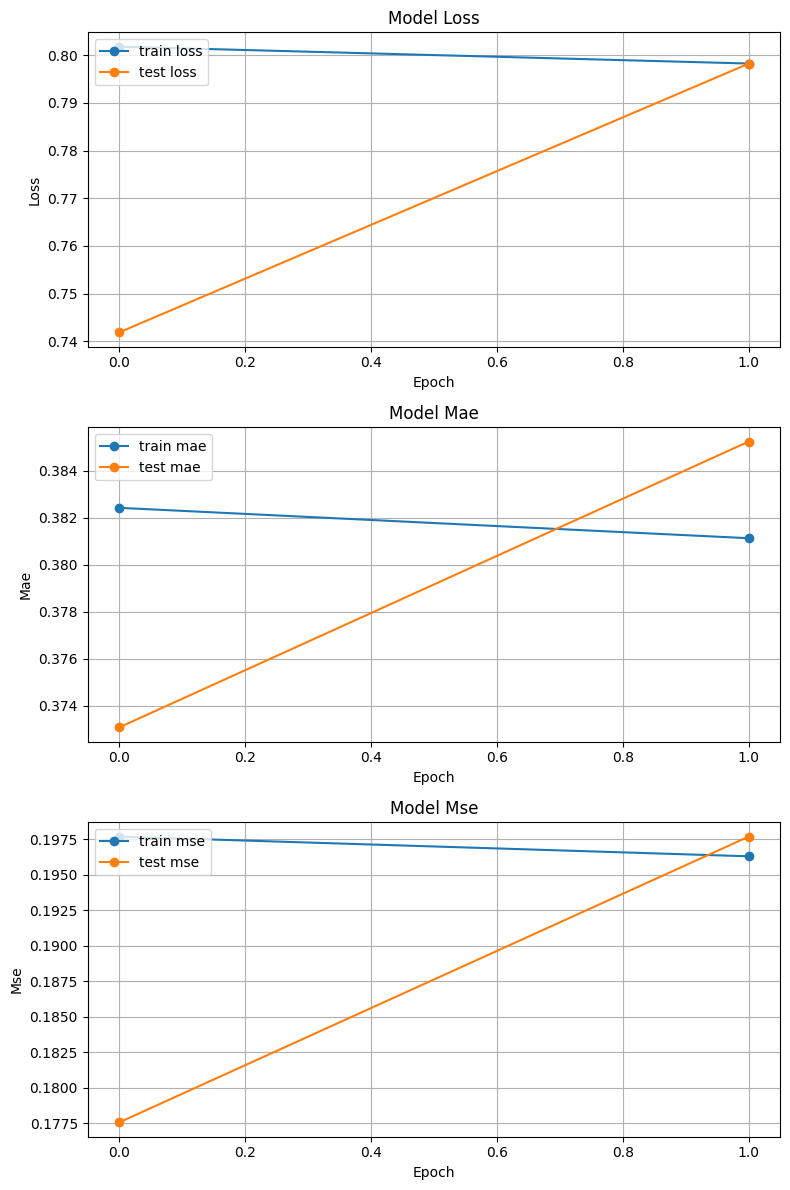

In [36]:
metrics = ["loss", "mae", "mse"]

# Create subplots
fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics) * 4))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric][0:-2], marker="o", label=f"train {metric}")
    ax.plot(history.history[f"val_{metric}"][0:-2], marker="o", label=f"test {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper left")
    ax.grid(True)

plt.tight_layout()
plt.show()

In [37]:
def extract_weights(name, model):
    weight_layer=model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights=weights/np.linalg.norm(weights, axis=1).reshape(-1, 1)
    return weights

In [38]:
anime_weights=extract_weights("anime_embedding", model)

In [39]:
user_weights=extract_weights("user_embedding", model)

# Reading anime.csv

In [40]:
df=pd.read_csv(INPUT_DIR + "/anime.csv", low_memory=True)

In [41]:
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [42]:
df=df.replace("Unknown", np.nan)

In [43]:
def getAnimeName(anime_id):
    try:
        name=df[df.anime_id == anime_id].eng_version.values[0]
        if name==np.nan:
            name=df[df.anime_id == anime_id].name.values[0]
    except:
        print("Error")

    return name

In [44]:
df["anime_id"]=df["MAL_ID"]
df["eng_version"]=df["English name"]
df["eng_version"]=df.anime_id.apply(lambda x: getAnimeName(x))

In [45]:
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,1,Cowboy Bebop
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",NaN,...,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0,5,Cowboy Bebop:The Movie
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0,6,Trigun
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0,7,Witch Hunter Robin
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0,8,Beet the Vandel Buster


In [46]:
getAnimeName(1000)

'Space Pirate Captain Harlock'

In [47]:
df.sort_values(by=["Score"],
               inplace=True,
               ascending=False,
               kind="quicksort",
               na_position="last")

In [48]:
df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'anime_id',
       'eng_version'],
      dtype='object')

In [49]:
df=df[['anime_id', 'eng_version', 'Score', 'Genres', 'Episodes', 'Type', 'Premiered', 'Members']].drop_duplicates().reset_index(drop=True)

In [50]:
df.head()

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
0,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,Spring 2009,2248456
1,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260
2,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162
3,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",10,TV,Spring 2019,1073626
4,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",51,TV,Spring 2015,404121


In [51]:
def getAnimeFrame(anime, df):
    if isinstance(anime, int):
        return df[df.anime_id == anime]
    
    if isinstance(anime, str):
        return df[df.eng_version == anime]

In [52]:
getAnimeFrame("Attack on Titan Final Season", df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
1,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260


# Working with anime with synopsis.csv

In [53]:
cols=["MAL_ID", "Name", "Genres", "sypnopsis"]

In [54]:
synopsis_df=pd.read_csv(os.path.join(INPUT_DIR, "anime_with_synopsis.csv"), low_memory=True, usecols=cols)

In [55]:
synopsis_df.head()

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."
2,6,Trigun,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0..."
3,7,Witch Hunter Robin,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...
4,8,Bouken Ou Beet,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...


In [56]:
def getSynopsis(anime,synopsis_df):
    if isinstance(anime,int):
        return synopsis_df[synopsis_df.MAL_ID == anime].sypnopsis.values[0]
    if isinstance(anime,str):
        return synopsis_df[synopsis_df.Name == anime].sypnopsis.values[0]
    

In [57]:
getSynopsis(40028 , synopsis_df)

"Gabi Braun and Falco Grice have been training their entire lives to inherit one of the seven titans under Marley's control and aid their nation in eradicating the Eldians on Paradis. However, just as all seems well for the two cadets, their peace is suddenly shaken by the arrival of Eren Yeager and the remaining members of the Survey Corps. Having finally reached the Yeager family basement and learned about the dark history surrounding the titans, the Survey Corps has at long last found the answer they so desperately fought to uncover. With the truth now in their hands, the group set out for the world beyond the walls. In Shingeki no Kyojin: The Final Season , two utterly different worlds collide as each party pursues its own agenda in the long-awaited conclusion to Paradis' fight for freedom."

### Content/Item based recommendation system

In [58]:
pd.set_option("max_colwidth", None)

In [59]:
def find_similar_animes(name, anime_weights, anime2anime_encoded, anime2anime_decoded, df, synopsis_df, n=10, return_dist=False, neg=False):
    # Get the anime_id for the given name
    try:
        index = getAnimeFrame(name, df).anime_id.values[0]
        encoded_index = anime2anime_encoded.get(index)

        if encoded_index is None:
            raise ValueError(f"Encoded index not found for anime ID: {index}")

        weights = anime_weights

        # Compute the similarity distances
        dists = np.dot(weights, weights[encoded_index])  # Ensure weights[encoded_index] is a 1D array
        sorted_dists = np.argsort(dists)

        n = n + 1

        # Select closest or farthest based on 'neg' flag
        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]

        # Return distances and closest indices if requested
        if return_dist:
            return dists, closest

        # Build the similarity array
        SimilarityArr = []
        for close in closest:
            decoded_id = anime2anime_decoded.get(close)
        
            anime_frame = getAnimeFrame(decoded_id, df)

            anime_name = anime_frame.eng_version.values[0]
            genre = anime_frame.Genres.values[0]
            similarity = dists[close]
    

            SimilarityArr.append({
                "anime_id": decoded_id,
                "name": anime_name,
                "similarity": similarity,
                "genre": genre
            })
        

        # Create a DataFrame with results and sort by similarity
        Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
        return Frame[Frame.anime_id != index].drop(['anime_id'], axis=1)
    
    except Exception as e:
        print(f"Error: {e}")


In [60]:
find_similar_animes("Steins;Gate", anime_weights, anime2anime_encoded, anime2anime_decoded, df, synopsis_df)

,name,similarity,genre
9,Devil's Organ,0.322275,"Music, Horror, Demons"
8,NaN,0.311177,"Drama, Fantasy, Shoujo"
7,NaN,0.301002,Comedy
6,NaN,0.298939,"Sci-Fi, Mystery, Psychological, Supernatural, Drama"
5,NaN,0.287238,Music
4,NaN,0.283486,"Action, Magic, Comedy, Super Power, Supernatural, Shounen"
3,Transformers The Headmasters,0.278653,"Action, Sci-Fi, Adventure, Space, Mecha, Shounen"
2,Demon City Shinjuku,0.276533,"Adventure, Horror, Romance, Shounen, Supernatural"
1,NaN,0.274982,"Comedy, Seinen, Slice of Life"
0,NaN,0.274707,"Action, Military"


### User based recommendation

In [61]:
def find_similar_users(item_input, user_weights, user2user_encoded, user2user_decoded, n=10, return_dist=False, neg=False):
    try:
        index=item_input
        encoded_index=user2user_encoded.get(index)

        weights=user_weights

        dists=np.dot(weights, weights[encoded_index])
        sorted_dists=np.argsort(dists)

        n = n + 1
        if neg:
            closest=sorted_dists[:n]
        else:
            closest=sorted_dists[-n:]

        if return_dist:
            return dists, closest
        
        SimilarityArr = []
        for close in closest:
            similarity = dists[close]

            if isinstance(item_input, int):
                decoded_id = user2user_decoded.get(close)
                
                SimilarityArr.append({
                    "similar_users": decoded_id,
                    "similarity": similarity
                })

        # Create a DataFrame with results and sort by similarity
        similar_users = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
        return similar_users[similar_users.similar_users != item_input]

    except Exception as e:
        print(f"Error: {e}")
        return None

In [62]:
find_similar_users(int(1000), user_weights, user2user_encoded, user2user_decoded)

,similar_users,similarity
9,10100,0.315400
8,8354,0.292951
7,4409,0.287952
6,6139,0.273451
5,11048,0.270422
4,8512,0.269875
3,1619,0.267333
2,12888,0.253767
1,7038,0.246632
0,10441,0.245343


In [63]:
def showWordCloud(all_genres):
    genres_cloud= WordCloud(
        width=700,
        height=400,
        background_color="white",
        colormap="viridis").generate_from_frequencies(all_genres)
    plt.figure(figsize=(10, 8))
    plt.imshow(genres_cloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [64]:
from collections import defaultdict

In [65]:
df.head()

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
0,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen",64,TV,Spring 2009,2248456
1,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen",16,TV,Winter 2021,733260
2,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162
3,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Shounen, Super Power",10,TV,Spring 2019,1073626
4,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen",51,TV,Spring 2015,404121


In [66]:
def getFavGenre(frame, plot=False):
    frame.dropna(inplace=False)
    all_genres = defaultdict(int)

    genres_list=[]
    for genre in frame["Genres"]:
        if isinstance(genre, str):
            for genre in genre.split(","):
                genres_list.append(genre.strip())
                all_genres[genre.strip()] += 1

    if plot:
        showWordCloud(all_genres)
    return genres_list

In [67]:
x=getAnimeFrame(1,df)

In [68]:
x

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
28,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",26,TV,Spring 1998,1251960


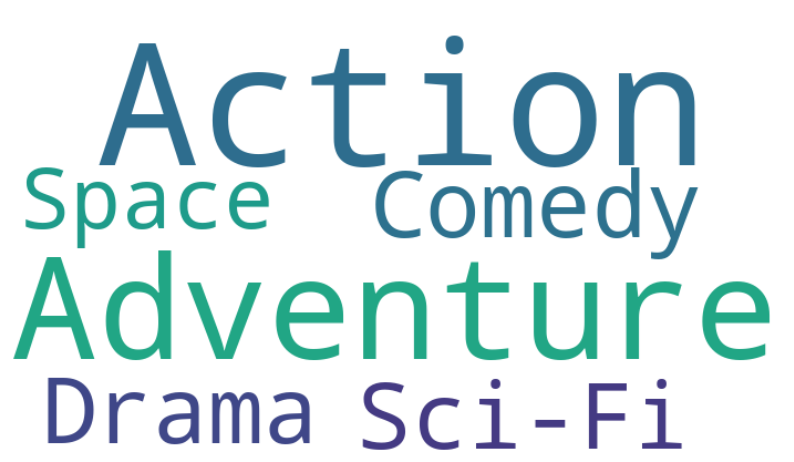

['Action', 'Adventure', 'Comedy', 'Drama', 'Sci-Fi', 'Space']

In [69]:
getFavGenre(x, plot=True)

In [70]:
rating_df.head()

,user_id,anime_id,rating,user,anime
0,457,18153,0.9,120,1377
1,4903,20507,0.7,1195,1216
2,6313,23325,0.0,1591,1239
3,15851,37491,0.0,4024,1813
4,1596,29803,0.9,415,353


In [71]:
def get_user_preferences(user_id, rating_df, df, plot=False):
    animes_watched_by_user = rating_df[rating_df.user_id == user_id]

    user_rating_percentile=np.percentile(animes_watched_by_user.rating, 75)
    animes_watched_by_user=animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentile]

    top_animes_user=(
        animes_watched_by_user.sort_values(by="rating", ascending=False).anime_id.values
    )
    anime_df_rows=df[df["anime_id"].isin(top_animes_user)]
    anime_df_rows=anime_df_rows[["eng_version", "Genres"]]

    if plot:
        getFavGenre(anime_df_rows, plot=True)

    return anime_df_rows

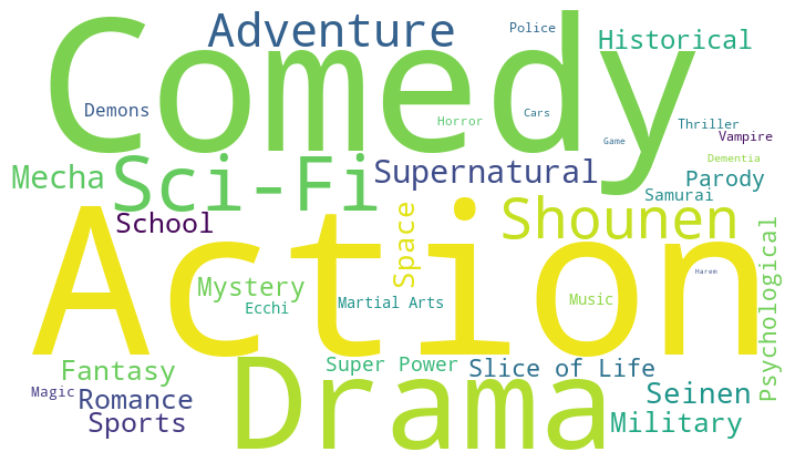

,eng_version,Genres
0,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
4,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
5,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
7,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
...,...,...
3869,Shootfighter Tekken,"Action, Martial Arts, Shounen"
4125,Samurai Flamenco,"Action, Comedy, Parody, Super Power"
4771,Venus Wars,"Action, Sci-Fi, Adventure, Space"
7611,NaN,"Action, Adventure, Fantasy, Shounen"


In [72]:
get_user_preferences(11880, rating_df, df, plot=True)

In [73]:
find_similar_users(int(11880), user_weights, user2user_encoded, user2user_decoded)

,similar_users,similarity
9,13770,0.292258
8,11045,0.275041
7,1581,0.273690
6,8374,0.270117
5,4152,0.265581
4,12503,0.259988
3,7428,0.257980
2,3651,0.253447
1,2820,0.252824
0,10314,0.245009


In [74]:
def get_user_recommendations(similar_users , user_pref ,df , synopsis_df, rating_df, n=10):

    recommended_animes = []
    anime_list = []

    for user_id in similar_users.similar_users.values:
        pref_list = get_user_preferences(int(user_id) , rating_df, df)

        pref_list = pref_list[~pref_list.eng_version.isin(user_pref.eng_version.values)]

        if not pref_list.empty:
            anime_list.append(pref_list.eng_version.values)

    if anime_list:
            anime_list = pd.DataFrame(anime_list)

            sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)

            for i,anime_name in enumerate(sorted_list.index):
                n_user_pref = sorted_list[sorted_list.index == anime_name].values[0][0]

                if isinstance(anime_name,str):
                    frame = getAnimeFrame(anime_name,df)
                    anime_id = frame.anime_id.values[0]
                    genre = frame.Genres.values[0]
                    synopsis = getSynopsis(int(anime_id),synopsis_df)

                    recommended_animes.append({
                        "n" : n_user_pref,
                        "anime_name" : anime_name,
                        "Genres" : genre,
                        "Synopsis": synopsis
                    })
    return pd.DataFrame(recommended_animes).head(n)

In [75]:
similar_users =find_similar_users(int(11880),user_weights,user2user_encoded,user2user_decoded)
user_pref = get_user_preferences(11880 , rating_df, df , plot=False)

In [76]:
user_pref

,eng_version,Genres
0,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
4,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
5,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
7,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
...,...,...
3869,Shootfighter Tekken,"Action, Martial Arts, Shounen"
4125,Samurai Flamenco,"Action, Comedy, Parody, Super Power"
4771,Venus Wars,"Action, Sci-Fi, Adventure, Space"
7611,NaN,"Action, Adventure, Fantasy, Shounen"


In [77]:
get_user_recommendations(similar_users,user_pref,df, synopsis_df,rating_df,n=10)

,n,anime_name,Genres,Synopsis
0,9,Attack on Titan,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen","Centuries ago, mankind was slaughtered to near extinction by monstrous humanoid creatures called titans, forcing humans to hide in fear behind enormous concentric walls. What makes these giants truly terrifying is that their taste for human flesh is not born out of hunger but what appears to be out of pleasure. To ensure their survival, the remnants of humanity began living within defensive barriers, resulting in one hundred years without a single titan encounter. However, that fragile calm is soon shattered when a colossal titan manages to breach the supposedly impregnable outer wall, reigniting the fight for survival against the man-eating abominations. After witnessing a horrific personal loss at the hands of the invading creatures, Eren Yeager dedicates his life to their eradication by enlisting into the Survey Corps, an elite military unit that combats the merciless humanoids outside the protection of the walls. Based on Hajime Isayama's award-winning manga, Shingeki no Kyojin follows Eren, along with his adopted sister Mikasa Ackerman and his childhood friend Armin Arlert, as they join the brutal war against the titans and race to discover a way of defeating them before the last walls are breached."
1,8,Spirited Away,"Adventure, Supernatural, Drama","Stubborn, spoiled, and naïve, 10-year-old Chihiro Ogino is less than pleased when she and her parents discover an abandoned amusement park on the way to their new house. Cautiously venturing inside, she realizes that there is more to this place than meets the eye, as strange things begin to happen once dusk falls. Ghostly apparitions and food that turns her parents into pigs are just the start—Chihiro has unwittingly crossed over into the spirit world. Now trapped, she must summon the courage to live and work amongst spirits, with the help of the enigmatic Haku and the cast of unique characters she meets along the way. Vivid and intriguing, Sen to Chihiro no Kamikakushi tells the story of Chihiro's journey through an unfamiliar world as she strives to save her parents and return home."
2,8,Attack on Titan Season 2,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen","For centuries, humanity has been hunted by giant, mysterious predators known as the Titans. Three mighty walls—Wall Maria, Rose, and Sheena—provided peace and protection for humanity for over a hundred years. That peace, however, was shattered when the Colossus Titan and Armored Titan appeared and destroyed the outermost wall, Wall Maria. Forced to retreat behind Wall Rose, humanity waited with bated breath for the Titans to reappear and destroy their safe haven once more. In Shingeki no Kyojin Season 2 , Eren Yeager and others of the 104th Training Corps have just begun to become full members of the Survey Corps. As they ready themselves to face the Titans once again, their preparations are interrupted by the invasion of Wall Rose—but all is not as it seems as more mysteries are unraveled. As the Survey Corps races to save the wall, they uncover more about the invading Titans and the dark secrets of their own members."
3,7,Your Name.,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to live the life of a boy in the bustling city of Tokyo—a dream that stands in stark contrast to her present life in the countryside. Meanwhile in the city, Taki Tachibana lives a busy life as a high school student while juggling his part-time job and hopes for a future in architecture. One day, Mitsuha awakens in a room that is not her own and suddenly finds herself living the dream life in Tokyo—but in Taki's body! Elsewhere, Taki finds himself living Mitsuha's life in the humble countryside. In pursuit of an answer to this strange phenomenon, they begin to search for one another. Kimi no Na wa. revolves around Mitsuha and Taki's actions, which begin to have a dramatic im

#### hybrid recommendation system

In [78]:
def hybrid_recommendation(user_id , user_weight=0.5, content_weight =0.5):

    ## User Recommndation

    similar_users =find_similar_users(user_id,user_weights,user2user_encoded,user2user_decoded)
    user_pref = get_user_preferences(user_id , rating_df, df)
    user_recommended_animes =get_user_recommendations(similar_users,user_pref,df, synopsis_df,rating_df)
    

    user_recommended_anime_list = user_recommended_animes["anime_name"].tolist()
    print(user_recommended_anime_list)

    #### Content recommendation
    content_recommended_animes = []

    for anime in user_recommended_anime_list:
        similar_animes = find_similar_animes(anime, anime_weights, anime2anime_encoded, anime2anime_decoded, df, synopsis_df)

        if similar_animes is not None and not similar_animes.empty:
            content_recommended_animes.extend(similar_animes["name"].tolist())
        else:
            print(f"No similar anime found {anime}")
    
    combined_scores = {}

    for anime in user_recommended_anime_list:
        combined_scores[anime] = combined_scores.get(anime,0) + user_weight

    for anime in content_recommended_animes:
        combined_scores[anime] = combined_scores.get(anime,0) + content_weight  

    sorted_animes = sorted(combined_scores.items() , key=lambda x:x[1] , reverse=True)

    return [anime for anime , score in sorted_animes[:10]] 



In [79]:
hybrid_recommendation(15597)

['Bakuman.', 'Naruto:Shippuden', "Kuroko's Basketball", 'Hellsing Ultimate', 'Kakegurui:Compulsive Gambler', 'Aldnoah.Zero', 'Soul Eater', 'Ergo Proxy', 'Naruto', 'Darker than Black']


[nan,
 'Bakuman.',
 'Naruto:Shippuden',
 "Kuroko's Basketball",
 'Hellsing Ultimate',
 'Kakegurui:Compulsive Gambler',
 'Aldnoah.Zero',
 'Soul Eater',
 'Ergo Proxy',
 'Naruto']